In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from copy import deepcopy
from dataclasses import dataclass
from pathlib import Path

import librosa
import numpy as np
import pandas as pd
import torch
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from torchmetrics.audio.dnsmos import DeepNoiseSuppressionMeanOpinionScore

# Agenda
1. [Intro](#Intro)
2. [Seq2seq TTS](#Seq2seq_tts)
3. [Tacotron](#Tacotron)
4. [Fine-tuning](#Finetuning) 

<a id='Intro'></a>
# 1. Intro

## [Speech Synthesis](https://paperswithcode.com/task/speech-synthesis)

Speech synthesis is the task of generating speech from some other modality like text, lip movements, etc.

**Subtasks**:

- Text To Speech (TTS) — Synthesize audio from text. [Coqui.ai](https://github.com/coqui-ai/TTS).
- [Text(Speech) To Speech Translation](https://paperswithcode.com/task/text-to-speech-translation) — Synthesize audio in another language from the original one OR original audio + translated text. [SeamlessM4T](https://huggingface.co/spaces/facebook/seamless_m4t).
- Vocoding — Synthesize audio from spectral or other intermidiate representations.

**Examples**:

- Pure TTS services: [Respeecher](https://www.respeecher.com/), [ElevenLabs](https://elevenlabs.io/) and many other startups and companies.
- Assistive Technology for Visually Impaired — TTS is crucial in screen readers and other assistive technologies, enabling visually impaired individuals to consume digital text content, including books, websites, and documents.
- Navigation and GPS Systems — In GPS and navigation apps, TTS provides spoken directions and traffic updates, allowing users to focus on driving without needing to look at the screen.
- Public Announcements — Airports, train stations, and public venues use TTS for announcements, ensuring clear and consistent communication of important information like boarding calls or emergency alerts.
- Audio Books and Storytelling — TTS technology allows for the creation of audiobooks from written content, making literature more accessible and convenient for busy individuals or those who prefer listening over reading.
- Automated News Reading and Podcasts — TTS is used to convert written news articles, blogs, and other content into spoken words, creating automated news reading services or podcasts.

![](../../Module_1/Lecture_1/images/diagrams-speech_synthesis.drawio.png)

<a id='Seq2seq_tts'></a>
# 2. Seq2seq TTS

Sequence-to-Sequence (Seq2Seq) models are designed to transform one sequence into another. You are probably familiar with Seq2Seq models in context of NLP in such tasks like `Machine Translation` or `Text Summarization`. Let's recall general architecture of these models: ![](https://blog.paperspace.com/content/images/2022/08/encoder.png)

- **Encoder:** Processes the input text sequence and encodes it into a fixed-dimensional context vector.

- **Decoder:** Generates the output sequence (e.g., mel spectrogram) from the context vector.

- **Attention Mechanism:** Allows the decoder to focus on different parts of the input sequence during generation, improving alignment between input and output.

> **Explore**: read more about [attention mechanisms](https://blog.paperspace.com/introduction-to-neural-machine-translation-with-bahdanaus-attention)

## 1.2 Text Tokenization Methods in TTS

Tokenization is the process of converting raw text into a sequence of tokens that the model can process. In TTS, the choice of tokenization impacts pronunciation accuracy and model performance.

- **Character-Level Tokenization:**
  - *Description*: Splits text into individual characters.
  - *Example*: "Hello" → ['H', 'e', 'l', 'l', 'o']
  - *Usage*: Employed in models like Tacotron 2 for simplicity.

- **Phoneme-Level Tokenization:**
  - *Description*: Converts text into phonemes using Grapheme-to-Phoneme (G2P) [models](https://github.com/CiscoDevNet/g2p_seq2seq_pytorch).
  - *Example*: "Hello" → ['HH', 'AH', 'L', 'OW']
  - *Usage*: Improves pronunciation accuracy, especially in languages with irregular spelling.

- **Subword Tokenization:**
  - *Description*: Breaks text into subword units using algorithms like Byte Pair Encoding (BPE).
  - *Example*: "unhappiness" → ['un', 'happi', 'ness']
  - *Usage*: Balances vocabulary size and representation granularity.

## 1.3 Audio Feature Representations in TTS

To synthesize speech, TTS models convert textual input into audio features before generating waveforms.

- **Mel Spectrograms:**
  - *Description*: Time-frequency representation emphasizing perceptually relevant frequencies.
  - *Usage*: Widely used in models like Tacotron 2 as an intermediate representation.

- **Linear Spectrograms:**
  - *Description*: Detailed frequency representation without perceptual scaling.
  - *Usage*: Provides more detailed frequency information but may be more sensitive to noise.

- **Raw Waveforms:**
  - *Description*: Direct representation of audio signals in the time domain.
  - *Usage*: Used in end-to-end models like WaveNet and Wave-Tacotron, eliminating the need for intermediate representations.

<a id='Tacotron'></a>
# 2. Tacotron

Tacotron 2, developed by NVIDIA, is a prominent Seq2Seq model for TTS. It combines a recurrent sequence-to-sequence feature prediction network with a vocoder to synthesize speech.

**Architecture Overview:**

![Tacotron 2 Architecture](https://pytorch.org/assets/images/tacotron2_diagram.png)

**Components:**

1. **Text Encoder:** Converts input text into a sequence of embeddings.

2. **Attention Mechanism:** Employs location-sensitive attention to align text and audio sequences.

3. **Decoder:** An autoregressive LSTM-based network that generates mel spectrogram frames.

4. **Post-Processing Network:** A convolutional network that refines the predicted mel spectrogram.

5. **Vocoder (WaveGlow):** Converts the mel spectrogram into time-domain waveform samples. __Important:__ Vocoder is trained separately from main model.

> **Explore:** [official](https://catalog.ngc.nvidia.com/orgs/nvidia/resources/tacotron_2_and_waveglow_for_pytorch/performance) Tacotron2 performance and documentation

## 2.1 Forward pass of the **Tacotron 2** model

$$
\begin{align*}
\{h_l\}_{l=1}^{L} &= \text{Encoder} \left( \{x_l\}_{l=1}^{L} \right) \\
p_t &= \text{Prenet}(o_{t-1}) \\
q_t &= \text{concat}(p_t, c_{t-1}) \\
a_t &= \text{Attention} \left( q_t, \{h_l\}_{l=1}^{L} \right) \\
c_t &= \sum_{l} a_{t,l} h_l \\
o_t &= \text{RNNs}(c_t) \\
o_t &= \{f_{t,r}, \dots, f_{t,r+r}\} \\
\{o_t\}_{t=1}^{T}, \{a_t\}_{t=1}^{T} &= \text{Decoder} \left( \{h_i\}_{i=1}^{L}; r \right) \\
\{f_k^P\}_{k=1}^{K} &= \text{Postnet} \left( \{f_k^D\}_{k=1}^{K} \right) \\
L &= \lVert f^P - y \rVert + \lVert f^D - y \rVert
\end{align*}
$$


1. **Encoder**
    - **Input:** $\{x_l\}_{l=1}^L$ — a sequence of input tokens (typically character embeddings).
    - **Output:** $\{h_l\}_{l=1}^L$ — a sequence of encoder hidden states.
      - The encoder uses convolutional layers followed by a bidirectional LSTM to process the input and generate contextualized representations of each token.

2. **Decoder Loop (for each timestep $t$)**

    2.1. **Prenet:** The previous output $o_{t-1}$ (i.e., the mel frame at $t-1$) is passed through a small feedforward network (Prenet) to improve robustness during inference.

    2.2 **Attention Query:** The attention query vector is formed by concatenating the prenet output with the context vector from the previous timestep.

    2.3 **Attention Weights:** The attention mechanism compares $q_t$ with the encoder outputs to produce attention weights over the input sequence.

    2.4 **Context Vector:** The attention weights are used to compute a weighted sum over encoder outputs—this is the **context vector** for the current decoding step.


3. **Decoder RNNs:**
    - $o_t = \text{RNNs}(c_t)$: The context vector $c_t$ is fed into a stack of LSTM layers (the decoder) to generate the next output frame.

    - $o_t = \{f_{t,r}, \dots, f_{t, r+r}\}$: Rather than predicting one frame at a time, Tacotron 2 predicts **r frames per step** to speed up training and inference.


4. **Outputs:** ${o_t}, {a_t}$ — over $T$ decoding steps, the model produces a sequence of mel spectrogram frames and attention weights.


5. **Postnet:** A CNN-based module refines the raw decoder output to improve audio quality by capturing residual information.

> **Explore:** implementation in [code](https://github.com/NVIDIA/tacotron2/blob/master/model.py) of model layers and forward pass

<a id='Finetuning'></a>
# 3. Fine-tuning

For model tuning we will use ["The LJ Speech Dataset"](https://www.kaggle.com/datasets/mathurinache/the-lj-speech-dataset).

This is a public domain speech dataset consisting of 13,100 short audio clips of a single speaker reading passages from 7 non-fiction books. A transcription is provided for each clip. Clips vary in length from 1 to 10 seconds and have a total length of approximately 24 hours.

The texts were published between 1884 and 1964, and are in the public domain. The audio was recorded in 2016-17 by the LibriVox project and is also in the public domain.

## 3.1. Loading data

Let's look at the sample of speech in our dataset.

In [2]:
# # Uncomment it to download
# !kaggle datasets download mathurinache/the-lj-speech-dataset --path ../../data/
# !mkdir ../../data/LJSpeech
# !unzip -q ../../data/the-lj-speech-dataset.zip -d ../../data/LJSpeech

In [3]:
data_path = Path('../../data/LJSpeech/LJSpeech-1.1/')
wave, sr = librosa.load(data_path / 'wavs' / 'LJ001-0001.wav')
Audio(wave, rate=sr)

In [4]:
list(data_path.iterdir())

[PosixPath('../../data/LJSpeech/LJSpeech-1.1/wavs'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/README'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/metadata_full.csv'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/metadata.csv'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/train.csv'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/test.csv'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/eval.csv')]

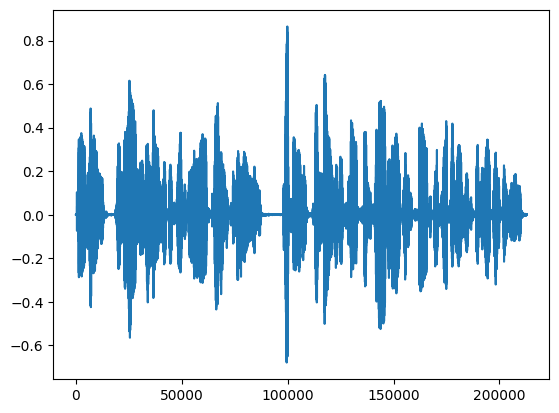

In [5]:
plt.plot(wave)

Then let's investigate the metadata of our dataset i.e. texts for each wav file.

In [6]:
with open(data_path / 'metadata.csv', 'r') as f:
    print(f.read(1000))

LJ001-0001|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
LJ001-0002|in being comparatively modern.|in being comparatively modern.
LJ001-0003|For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process|For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process
LJ001-0004|produced the block books, which were the immediate predecessors of the true printed book,|produced the block books, which were the immediate predecessors of the true printed book,
LJ001-0005|the invention of movable metal letters in the middle of the fifteenth century may justl

In [7]:
metadata = []
with open(data_path / 'metadata.csv', 'r') as f:
    for line in f:
        speaker_name, text, normalized_text = line.strip().split('|')
        metadata.append(
            {
                'wav-name': speaker_name + '.wav',
                'text': text,
                'normalized-text': normalized_text
            }
        )
metadata = pd.DataFrame(metadata)
metadata

,wav-name,text,normalized-text
0,LJ001-0001.wav,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002.wav,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003.wav,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004.wav,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005.wav,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
...,...,...,...
13095,LJ050-0274.wav,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275.wav,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276.wav,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277.wav,with the active cooperation of the responsible...,with the active cooperation of the responsible...


In [8]:
metadata.iloc[44:45]

,wav-name,text,normalized-text
44,LJ001-0045.wav,"1469, 1470;","fourteen sixty-nine, fourteen seventy;"


In [9]:
metadata.to_csv(data_path / 'metadata_full.csv', sep='|', index=False, header=False)

### Splitting data

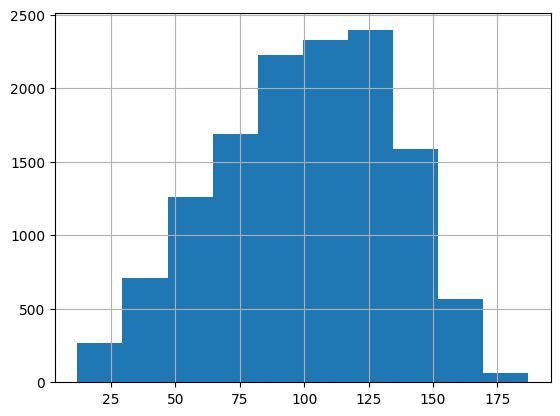

In [10]:
metadata['text-len'] = metadata['normalized-text'].str.len()
metadata['text-len'].hist();

In [11]:
# Define text-length bins for stratify splitting
bins = [0, 50, 100, 150, 200]
metadata['text-bins'] = pd.cut(metadata['text-len'], bins)
metadata

,wav-name,text,normalized-text,text-len,text-bins
0,LJ001-0001.wav,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ...",151,"(150, 200]"
1,LJ001-0002.wav,in being comparatively modern.,in being comparatively modern.,30,"(0, 50]"
2,LJ001-0003.wav,For although the Chinese took impressions from...,For although the Chinese took impressions from...,155,"(150, 200]"
3,LJ001-0004.wav,"produced the block books, which were the immed...","produced the block books, which were the immed...",89,"(50, 100]"
4,LJ001-0005.wav,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...,143,"(100, 150]"
...,...,...,...,...,...
13095,LJ050-0274.wav,made certain recommendations which it believes...,made certain recommendations which it believes...,65,"(50, 100]"
13096,LJ050-0275.wav,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...,150,"(100, 150]"
13097,LJ050-0276.wav,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no...",142,"(100, 150]"
13098,LJ050-0277.wav,with the active cooperation of the responsible...,with the active cooperation of the responsible...,156,"(150, 200]"


In [12]:
metadata_ = metadata.sample(5000, random_state=42)
# metadata_ = metadata
train_df, test_df = train_test_split(metadata_, test_size=0.2, stratify=metadata_['text-bins'], random_state=42)
eval_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['text-bins'], random_state=42)
train_df.shape, eval_df.shape, test_df.shape

((4000, 5), (500, 5), (500, 5))

In [13]:
train_df.iloc[:, :3].to_csv(data_path / 'train.csv', sep='|', index=False, header=False)
eval_df.iloc[:, :3].to_csv(data_path / 'eval.csv', sep='|', index=False, header=False)
test_df.iloc[:, :3].to_csv(data_path / 'test.csv', sep='|', index=False, header=False)

In [14]:
list(data_path.iterdir())

[PosixPath('../../data/LJSpeech/LJSpeech-1.1/wavs'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/README'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/metadata_full.csv'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/metadata.csv'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/train.csv'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/test.csv'),
 PosixPath('../../data/LJSpeech/LJSpeech-1.1/eval.csv')]

## 3.2. Loading model

In [15]:
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
sum([param.numel() for param in tacotron2.parameters() if param.requires_grad])

Using cache found in /home/vsydorskyi/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vsydorskyi/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vsydorskyi/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


28193153

In [16]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')

Using cache found in /home/vsydorskyi/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/data/vsydorskyi/src/ucu_audio_processing_course/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [17]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

Using cache found in /home/vsydorskyi/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


### Base model inference example

In [18]:
tacotron2.eval()
waveglow.eval()
text = metadata.iloc[0]['normalized-text']
text

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

In [19]:
sequences, lengths = utils.prepare_input_sequence([text])
with torch.inference_mode():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050
Audio(audio_numpy, rate=rate)

In [20]:
Audio(filename=data_path / 'wavs' / metadata.iloc[0]['wav-name'])

## 3.3. Training

#### Tacotron 2 Loss

$$L_{\text{model}} = \underbrace{\|f^P - y\|^2 + \|f^D - y\|^2}_{\text{Mel-spectrogram MSE loss}} + \underbrace{\text{BCEWithLogits}(g, g_{\text{target}})}_{\text{Gate loss}}$$

Where:
- $ f^P $ — mel spectrogram predicted by the decoder (before postnet)
- $ f^D $ — mel spectrogram predicted after postnet
- $ y $ — ground truth mel spectrogram
- $ g $ — gate output (logits)
- $ g_{\text{target}} $ — ground truth end-of-sequence flags (1 if EOS, 0 otherwise)

In [21]:
class Tacotron2Loss(nn.Module):
    def __init__(self):
        super(Tacotron2Loss, self).__init__()

    def forward(self, model_output, targets):
        mel_target, gate_target = targets[0], targets[1]
        mel_target.requires_grad = False
        gate_target.requires_grad = False
        gate_target = gate_target.view(-1, 1)

        mel_out, mel_out_postnet, gate_out, _ = model_output
        gate_out = gate_out.view(-1, 1)
        mel_loss = nn.MSELoss()(mel_out, mel_target) + \
                   nn.MSELoss()(mel_out_postnet, mel_target)
        gate_loss = nn.BCEWithLogitsLoss()(gate_out, gate_target)
        return mel_loss + gate_loss

#### Model config

In [22]:
@dataclass
class AudioConfig:
    """Configuration for audio processing and mel-spectrogram generation.

    Attributes:
        dataset_path: Path to the dataset directory
        wav_files: Path to filelist with audio paths and text
        mel_files: Path to filelist with mel paths and text
        text_cleaners: List of text cleaner types for input text
        max_wav_value: Maximum audiowave value
        sampling_rate: Audio sampling rate in Hz
        filter_length: Length of the filter for spectogram generation
        hop_length: Number of samples between successive frames
        win_length: Window size for STFT
        mel_fmin: Minimum frequency for mel filterbank
        mel_fmax: Maximum frequency for mel filterbank
        n_mel_channels: Number of mel filterbank channels
    """
    dataset_path: str = "./"
    wav_files: str = None
    mel_files: str = None
    text_cleaners: list[str] = ("english_cleaners",)
    max_wav_value: float = 32768.0
    sampling_rate: int = 22050
    filter_length: int = 1024
    hop_length: int = 256
    win_length: int = 1024
    mel_fmin: float = 0.0
    mel_fmax: float = 8000.0
    n_mel_channels: int = 80
    load_mel_from_disk = None

    def to_dict(self) -> dict:
        """Convert the configuration to a dictionary."""
        return {
            field.name: getattr(self, field.name)
            for field in self.__dataclass_fields__.values()
        }

#### Dataset and collate function

In [23]:
import tacotron2_common.layers as layers
from tacotron2_common.utils import load_wav_to_torch, load_filepaths_and_text, to_gpu
from text import text_to_sequence


class TextMelLoader(Dataset):
    """
        1) loads audio,text pairs
        2) normalizes text and converts them to sequences of one-hot vectors
        3) computes mel-spectrograms from audio files.
    """

    def __init__(self, dataset_path, audiopaths_and_text, args):
        self.audiopaths_and_text = load_filepaths_and_text(dataset_path, audiopaths_and_text)
        self.text_cleaners = args.text_cleaners
        self.max_wav_value = args.max_wav_value
        self.sampling_rate = args.sampling_rate
        self.load_mel_from_disk = args.load_mel_from_disk
        self.stft = layers.TacotronSTFT(
            args.filter_length, args.hop_length, args.win_length,
            args.n_mel_channels, args.sampling_rate, args.mel_fmin,
            args.mel_fmax
        )

    def get_mel_text_pair(self, audiopath_and_text):
        # separate filename and text
        audiopath, text = audiopath_and_text[0], audiopath_and_text[1]
        len_text = len(text)
        text = self.get_text(text)
        mel = self.get_mel(audiopath)
        return (text, mel, len_text)

    def get_mel(self, filename):
        if not self.load_mel_from_disk:
            audio, sampling_rate = load_wav_to_torch(filename)
            if sampling_rate != self.stft.sampling_rate:
                raise ValueError(
                    "{} {} SR doesn't match target {} SR".format(
                        sampling_rate, self.stft.sampling_rate
                    )
                )
            audio_norm = audio / self.max_wav_value
            audio_norm = audio_norm.unsqueeze(0)
            audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
            melspec = self.stft.mel_spectrogram(audio_norm)
            melspec = torch.squeeze(melspec, 0)
        else:
            melspec = torch.load(filename)
            assert melspec.size(0) == self.stft.n_mel_channels, (
                'Mel dimension mismatch: given {}, expected {}'.format(
                    melspec.size(0), self.stft.n_mel_channels
                ))

        return melspec

    def get_text(self, text):
        text_norm = torch.IntTensor(text_to_sequence(text, self.text_cleaners))
        return text_norm

    def __getitem__(self, index):
        return self.get_mel_text_pair(self.audiopaths_and_text[index])

    def __len__(self):
        return len(self.audiopaths_and_text)

In [24]:
class TextMelCollate:
    """ Zero-pads model inputs and targets based on number of frames per setep
    """

    def __init__(self, n_frames_per_step):
        self.n_frames_per_step = n_frames_per_step

    def __call__(self, batch):
        """Collate's training batch from normalized text and mel-spectrogram
        PARAMS
        ------
        batch: [text_normalized, mel_normalized]
        """
        # Right zero-pad all one-hot text sequences to max input length
        input_lengths, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([len(x[0]) for x in batch]),
            dim=0, descending=True
        )
        max_input_len = input_lengths[0]

        text_padded = torch.LongTensor(len(batch), max_input_len)
        text_padded.zero_()
        for i in range(len(ids_sorted_decreasing)):
            text = batch[ids_sorted_decreasing[i]][0]
            text_padded[i, :text.size(0)] = text

        # Right zero-pad mel-spec
        num_mels = batch[0][1].size(0)
        max_target_len = max([x[1].size(1) for x in batch])
        if max_target_len % self.n_frames_per_step != 0:
            max_target_len += self.n_frames_per_step - max_target_len % self.n_frames_per_step
            assert max_target_len % self.n_frames_per_step == 0

        # include mel padded and gate padded
        mel_padded = torch.FloatTensor(len(batch), num_mels, max_target_len)
        mel_padded.zero_()
        gate_padded = torch.FloatTensor(len(batch), max_target_len)
        gate_padded.zero_()
        output_lengths = torch.LongTensor(len(batch))
        for i in range(len(ids_sorted_decreasing)):
            mel = batch[ids_sorted_decreasing[i]][1]
            mel_padded[i, :, :mel.size(1)] = mel
            gate_padded[i, mel.size(1) - 1:] = 1
            output_lengths[i] = mel.size(1)

        # count number of items - characters in text
        len_x = [x[2] for x in batch]
        len_x = torch.Tensor(len_x)
        return text_padded, input_lengths, mel_padded, gate_padded, \
            output_lengths, len_x

In [25]:
def batch_to_gpu(batch):
    text_padded, input_lengths, mel_padded, gate_padded, \
        output_lengths, len_x = batch
    text_padded = to_gpu(text_padded).long()
    input_lengths = to_gpu(input_lengths).long()
    max_len = torch.max(input_lengths.data).item()
    mel_padded = to_gpu(mel_padded).float()
    gate_padded = to_gpu(gate_padded).float()
    output_lengths = to_gpu(output_lengths).long()
    x = (text_padded, input_lengths, mel_padded, max_len, output_lengths)
    y = (mel_padded, gate_padded)
    len_x = torch.sum(output_lengths)
    return (x, y, len_x)

#### Train loop

In [26]:
def train_epoch(model, data_loader, criterion, optimizer, accumulation_steps=4):
    model.train()
    epoch_losses = []
    optimizer.zero_grad()
    accum_step_loss = 0
    with torch.amp.autocast(device_type='cuda'):
        for i, batch in enumerate(pbar := tqdm(data_loader)):
            x, y, len_x = batch_to_gpu(batch)

            output = model(x)
            loss = criterion(output, y) / accumulation_steps
            accum_step_loss += loss.item()

            loss.backward()
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

                epoch_losses.append(accum_step_loss)
                pbar.desc = f"Loss: {accum_step_loss:.4f}"
                accum_step_loss = 0

        if (i + 1) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()

    return epoch_losses

#### Evaluation

[Deep Noise Suppression Mean Opinion Score (DNSMOS)](https://arxiv.org/pdf/2010.15258) is a model-based metric, which tries to approximate MOS with DNN

![DNSMOS](images/DNSMOS_model.png)

In [27]:
def evaluate(model, dataloader, sr=22050):
    audios = []
    dnsmos = DeepNoiseSuppressionMeanOpinionScore(sr, False)
    model.eval()
    with torch.inference_mode():
        for batch in tqdm(dataloader):
            x, y, len_x = batch_to_gpu(batch)
            mel, _, _ = model.infer(x[0], x[1])
            audio = waveglow.infer(mel)[0].data.cpu()

            dnsmos.update(audio)
            audios.append(audio.numpy())

    return dict(zip(['p808_mos', 'mos_sig', 'mos_bak', 'mos_ovr'], dnsmos.compute()))

### Setup all together

In [28]:
tacotron2_args = AudioConfig(
    dataset_path=data_path,
    wav_files=data_path / 'wavs',
)

In [29]:
train_dataset = TextMelLoader(data_path / 'wavs', data_path / 'train.csv', tacotron2_args)
eval_dataset = TextMelLoader(data_path / 'wavs', data_path / 'eval.csv', tacotron2_args)
test_dataset = TextMelLoader(data_path / 'wavs', data_path / 'test.csv', tacotron2_args)

In [30]:
collate_fn = TextMelCollate(1)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
)

eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=10,
    shuffle=False,
    collate_fn=collate_fn,
    drop_last=False,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=10,
    shuffle=False,
    collate_fn=collate_fn,
    drop_last=False,
)

Firstly let's evaluate base Tacotron2 model on our dataset for future comparison.

In [31]:
evaluate(tacotron2, test_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:34<00:00,  4.29s/it]


{'p808_mos': tensor(3.4613, dtype=torch.float64),
 'mos_sig': tensor(3.1880, dtype=torch.float64),
 'mos_bak': tensor(4.0798, dtype=torch.float64),
 'mos_ovr': tensor(3.0981, dtype=torch.float64)}

Next, fine-tune our model.

In [32]:
# Loss and optimizer
criterion = Tacotron2Loss()
optimizer = torch.optim.Adam(tacotron2.parameters(), lr=1e-6, weight_decay=1e-6)

In [33]:
losses = []
best_metric = float('-inf')
best_model = None

for i in range(10):
    epoch_losses = train_epoch(tacotron2, train_dataloader, criterion, optimizer, accumulation_steps=9)
    losses.extend(epoch_losses)
    metrics = evaluate(tacotron2, eval_dataloader)
    print(metrics)
    if metrics['p808_mos'] > best_metric:
        best_metric = metrics['p808_mos']
        best_model = deepcopy(tacotron2.state_dict())
    latest_model = deepcopy(tacotron2.state_dict())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:40<00:00,  4.41s/it]


{'p808_mos': tensor(3.4273, dtype=torch.float64), 'mos_sig': tensor(3.1377, dtype=torch.float64), 'mos_bak': tensor(3.9174, dtype=torch.float64), 'mos_ovr': tensor(2.9561, dtype=torch.float64)}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:40<00:00,  4.41s/it]


{'p808_mos': tensor(3.3820, dtype=torch.float64), 'mos_sig': tensor(3.1323, dtype=torch.float64), 'mos_bak': tensor(3.9587, dtype=torch.float64), 'mos_ovr': tensor(2.9652, dtype=torch.float64)}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:39<00:00,  4.38s/it]


{'p808_mos': tensor(3.4665, dtype=torch.float64), 'mos_sig': tensor(3.1099, dtype=torch.float64), 'mos_bak': tensor(4.0038, dtype=torch.float64), 'mos_ovr': tensor(2.9630, dtype=torch.float64)}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:48<00:00,  4.56s/it]


{'p808_mos': tensor(3.2443, dtype=torch.float64), 'mos_sig': tensor(2.9206, dtype=torch.float64), 'mos_bak': tensor(3.8735, dtype=torch.float64), 'mos_ovr': tensor(2.8164, dtype=torch.float64)}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:44<00:00,  4.49s/it]


{'p808_mos': tensor(3.4773, dtype=torch.float64), 'mos_sig': tensor(3.0666, dtype=torch.float64), 'mos_bak': tensor(3.9724, dtype=torch.float64), 'mos_ovr': tensor(2.9320, dtype=torch.float64)}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:45<00:00,  4.51s/it]


{'p808_mos': tensor(3.2220, dtype=torch.float64), 'mos_sig': tensor(3.0775, dtype=torch.float64), 'mos_bak': tensor(3.9473, dtype=torch.float64), 'mos_ovr': tensor(2.9314, dtype=torch.float64)}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:46<00:00,  4.52s/it]


{'p808_mos': tensor(3.2548, dtype=torch.float64), 'mos_sig': tensor(3.0473, dtype=torch.float64), 'mos_bak': tensor(3.9669, dtype=torch.float64), 'mos_ovr': tensor(2.8984, dtype=torch.float64)}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:44<00:00,  4.50s/it]


{'p808_mos': tensor(3.3457, dtype=torch.float64), 'mos_sig': tensor(3.0498, dtype=torch.float64), 'mos_bak': tensor(4.0180, dtype=torch.float64), 'mos_ovr': tensor(2.9485, dtype=torch.float64)}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:44<00:00,  4.49s/it]


{'p808_mos': tensor(3.1521, dtype=torch.float64), 'mos_sig': tensor(2.9323, dtype=torch.float64), 'mos_bak': tensor(3.8750, dtype=torch.float64), 'mos_ovr': tensor(2.8152, dtype=torch.float64)}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:46<00:00,  4.53s/it]

{'p808_mos': tensor(3.3699, dtype=torch.float64), 'mos_sig': tensor(3.0432, dtype=torch.float64), 'mos_bak': tensor(4.0202, dtype=torch.float64), 'mos_ovr': tensor(2.9453, dtype=torch.float64)}


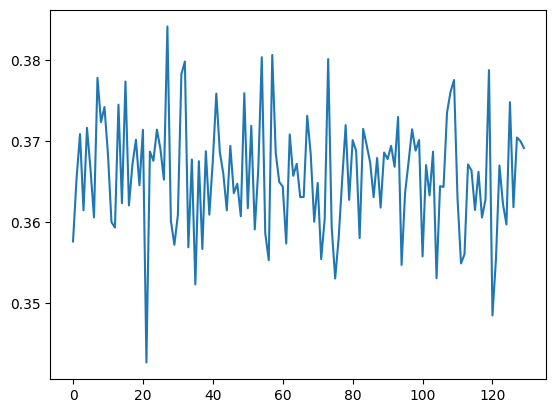

In [34]:
plt.plot(losses)

In [35]:
best_metric

tensor(3.4773, dtype=torch.float64)

In [36]:
torch.save(best_model, 'best.pt')
torch.save(latest_model, 'last.pt')

## 3.4. Inference

In [37]:
tacotron2.load_state_dict(best_model)
evaluate(tacotron2, test_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:50<00:00,  4.62s/it]


{'p808_mos': tensor(3.3273, dtype=torch.float64),
 'mos_sig': tensor(2.9941, dtype=torch.float64),
 'mos_bak': tensor(4.0601, dtype=torch.float64),
 'mos_ovr': tensor(2.9378, dtype=torch.float64)}

In [38]:
text

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

In [39]:
sequences, lengths = utils.prepare_input_sequence([text])
with torch.inference_mode():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
Audio(audio_numpy, rate=22050)

In [40]:
Audio(filename=data_path / 'wavs' / metadata.iloc[0]['wav-name'])